# Fingerprint-based similarity scores - ranking task

## Challenge
Often, fingerprints are used to find best matches in a dataaset or library. In this case, only the top-ranked similarities matter and it is not really important if a pair of mostly dissimilar compounds is placed in the 20 or 30% lowest percent.
Data:

## Data

Here we use the **ms2structures dataset** containing 37,811 unique compounds.

In [2]:
import os
from pathlib import Path
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

#from matchms.importing import load_from_mgf

ROOT = Path(os.getcwd()).parents[0]

path_data = os.path.join(Path(ROOT), "data")

In [3]:
filename = "compounds_ms2structures.csv"
compounds = pd.read_csv(os.path.join(path_data, filename))
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [4]:
compounds.shape

(37811, 10)

In [5]:
scaled_similarities_rdkit = np.load("scaled_similarities_tanimoto_rdkit_4096bits.npy")
scaled_similarities_morgan3 = np.load("scaled_similarities_tanimoto_morgan3_4096bits.npy")
scaled_similarities_morgan3_count = np.load("scaled_similarities_ruzicka_morgan3_4096bits.npy")
scaled_similarities_morgan9_count = np.load("scaled_similarities_ruzicka_morgan9_4096bits.npy")
scaled_similarities_map4 = np.load("scaled_similarities_tanimoto_map4_4096bits.npy")

In [6]:
scaled_similarities_map4_sparse = np.load("scaled_similarities_tanimoto_map4_sparse.npy")
scaled_similarities_morgan3_count_sparse = np.load("scaled_similarities_ruzicka_morgan3_sparse.npy")
scaled_similarities_morgan9_count_sparse = np.load("scaled_similarities_ruzicka_morgan9_sparse.npy")
scaled_similarities_morgan3_sparse = np.load("scaled_similarities_tanimoto_morgan3_sparse.npy")
scaled_similarities_rdkit_sparse = np.load("scaled_similarities_tanimoto_rdkit_sparse.npy")

## Find examples to illustrate regions

In [10]:
def get_score_summary(id1, id2):
    scores = {
        "Scaled Tanimoto (rdkit binary fp)": scaled_similarities_rdkit[id1, id2],
        "Scaled Tanimoto (Morgan-3 binary fp)": scaled_similarities_morgan3[id1, id2],
        "Scaled Tanimoto (MAP4 fp)": scaled_similarities_map4[id1, id2],
        "Scaled Ruzicka (Morgan-3 count fp)": scaled_similarities_morgan3_count[id1, id2],
        #"Scaled Ruzicka (Morgan-9 count fp)": scaled_similarities_morgan9_count[id1, id2],
    }
    scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return scores

In [7]:
def get_score_summary(id1, id2):
    output = f"Scaled Tanimoto (rdkit binary): {scaled_similarities_rdkit[id1, id2]:.4f}" \
    + f"(actual score: {similarities_rdkit[id1, id2]:.4f})\n"\
    + f"Scaled Tanimoto (Morgan-3 binary): {scaled_similarities_morgan3[id1, id2]:.4f}" \
    + f"(actual score: {similarities_morgan3[id1, id2]:.4f})\n"\
    + f"Scaled Tanimoto (MAP4 fp): {scaled_similarities_map4[id1, id2]}\n" \
    + f"Scaled Ruzicka (Morgan-3 count fp): {scaled_similarities_morgan3_count[id1, id2]:.4f}"\
    + f"(actual score: {similarities_morgan3_count[id1, id2]:.4f})\n"\
    #    "Scaled Ruzicka (Morgan-9 count fp)": scaled_similarities_morgan9_count[id1, id2],
    
    #scores = pd.DataFrame.from_dict(scores, orient='index', columns=["Score"])
    return output

In [22]:
def show_pairs(unique_pairs):
    for pair in unique_pairs:
        display(get_score_summary(pair[0], pair[1]))
    
        smiles1 = compounds.smiles[indices_selected[pair[0]]]
        smiles2 = compounds.smiles[indices_selected[pair[1]]]
        mol = Chem.MolFromSmiles(smiles1)
        display(mol)
        mol = Chem.MolFromSmiles(smiles2)
        display(mol)

In [30]:
from rdkit import Chem
from rdkit.Chem import Draw


def show_pairs_in_grid(unique_pairs, ncols=2, figsize=(30, 18), filename=None):
    nrows = -(-len(unique_pairs) // ncols)  # Ceiling division to get number of rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, pair in enumerate(unique_pairs):
        id1, id2 = pair
        ax = axes[i]
        
        # Get SMILES and render molecules
        smiles1 = compounds.smiles[id1]
        smiles2 = compounds.smiles[id2]
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        img = Draw.MolsToGridImage([mol1, mol2], molsPerRow=2, subImgSize=(800, 800), returnPNG=False)
        
        ax.imshow(img)
        ax.axis('off')
        
        # Get and display score summary below the molecules
        scores = get_score_summary(id1, id2)
        ax.set_title(f"Pair {i + 1}")
        ax.text(0.5, 0, scores, #.to_string(header=False), 
                transform=ax.transAxes, ha='center', fontsize=10, family='monospace')
    
    # Hide any unused subplots if number of pairs is less than grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


In [57]:
idx = 0
closest = np.argsort(scaled_similarities_morgan3_count[idx, :])[-10:][::-1]
closest

array([30175, 36848,  9615,  8183,  8579, 17172, 23609, 16152, 35875,
        5493])

In [59]:
scaled_similarities_morgan3_count[idx, closest], similarities_morgan3_count[idx, closest]

(array([99.99434 , 99.787704, 99.73819 , 99.71367 , 99.71313 , 99.70133 ,
        99.694466, 99.694466, 99.629715, 99.628296], dtype=float32),
 array([0.80530973, 0.47552448, 0.45070423, 0.43971631, 0.43949045,
        0.43448276, 0.43165468, 0.43165468, 0.40714286, 0.40666667]))

## How to compare ranking?

In [21]:
from scipy.stats import kendalltau, spearmanr

idx = 2
rank1 = np.argsort(scaled_similarities_morgan3_count[idx, :])
rank2 = np.argsort(scaled_similarities_rdkit[idx, :])

tau, _ = kendalltau(rank1, rank2)
rho, _ = spearmanr(rank1, rank2)

print(f"Kendall's Tau: {tau}, Spearman's Rho: {rho}")

Kendall's Tau: 0.004444409176245899, Spearman's Rho: 0.006684925248774106


In [26]:
def rank_agreement(rank1, rank2, k):
    return len(set(rank1[:k]) & set(rank2[:k])) / k

agreement_score = rank_agreement(rank1, rank2, 10)
print(f"Rank Agreement@10: {agreement_score}")

Rank Agreement@10: 0.2


In [67]:
labels

['Query compound',
 'Score: 0.8053',
 'Score: 0.4755',
 'Score: 0.4507',
 'Score: 0.4397',
 'Score: 0.4395',
 'Score: 0.4345',
 'Score: 0.4317',
 'Score: 0.4317',
 'Score: 0.4071',
 'Score: 0.4067']

In [172]:
# better classic: 3604f
# count besser: 3619, 3620, 3628, 3648

In [8]:
import numba

In [9]:
@numba.njit
def compute_overlap(arr1, arr2):
    total = 0
    for entry in arr1:
        if entry in arr2:
            total += 1
    return total

def total_overlaps(scores1, scores2, nn1=10, nn2=10, sample_size=5000):
    overlaps = []
    overlap_percentiles = []
    for idx in tqdm(range(sample_size)):
        closest1 = np.argsort(scores1[idx, :])[-nn1:][::-1]
        closest2 = np.argsort(scores2[idx, :])[-nn2:][::-1]
        overlap_percentiles.append((np.mean(scores1[idx, closest1]), np.mean(scores2[idx, closest1])))
        overlap = compute_overlap(closest1, closest2)
        overlaps.append(overlap)

    return np.array(overlaps), overlap_percentiles#np.array([x[0] - x[1] for x in overlap_percentiles])

  0%|          | 0/5000 [00:00<?, ?it/s]

(array([468., 575., 670., 657., 587., 559., 526., 440., 315., 203.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

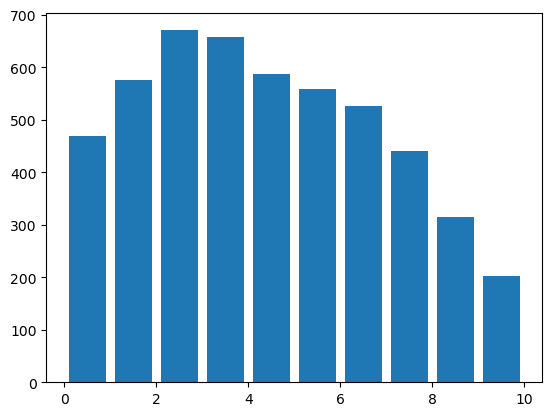

In [10]:
overlaps, overlap_percentiles = total_overlaps(scaled_similarities_rdkit, scaled_similarities_morgan3_count)
plt.hist(overlaps, rwidth=0.8)

In [77]:
percentiles_1 = np.array([x[0] for x in overlap_percentiles])
np.where(percentiles_1 < 50)

(array([1336, 2082]),)

In [79]:
compounds.smiles[2082]

'SC1=NN=C(S)S1'

In [82]:
compounds.sort_values("mass").head(20)

,inchikey,inchi,smiles,spectrum_id,mass
1627,BAVYZALUXZFZLV,"InChI=1S/CH5N/c1-2/h2H2,1H3",CN,CCMSLIB00000426397,31.058
20914,OKKJLVBELUTLKV,"InChI=1S/CH4O/c1-2/h2H,1H3",CO,CCMSLIB00000425511,32.042
1336,AVXURJPOCDRRFD,"InChI=1S/H3NO/c1-2/h2H,1H2",NO,CCMSLIB00000426338,33.030
33667,XLJMAIOERFSOGZ,InChI=1S/CHNO/c2-1-3/h3H/p-1,[O-]C#N,CCMSLIB00000425277,42.017
11496,IKHGUXGNUITLKF,"InChI=1S/C2H4O/c1-2-3/h2H,1H3",CC=O,CCMSLIB00000425464,44.053
24606,QUSNBJAOOMFDIB,"InChI=1S/C2H7N/c1-2-3/h2-3H2,1H3",CCN,MSBNK-Keio_Univ-KO002856,45.085
25856,ROSDSFDQCJNGOL,"InChI=1S/C2H7N/c1-3-2/h3H,1-2H3",CNC,MSBNK-Keio_Univ-KO002757,45.085
11770,IOVCWXUNBOPUCH,"InChI=1S/HNO2/c2-1-3/h(H,2,3)/p-1",[O-]N=O,CCMSLIB00000425793,46.005
18770,NBBJYMSMWIIQGU,"InChI=1S/C3H6O/c1-2-3-4/h3H,2H2,1H3",CCC=O,CCMSLIB00000425392,58.080
4251,CSCPPACGZOOCGX,InChI=1S/C3H6O/c1-3(2)4/h1-2H3,CC(C)=O,CCMSLIB00000425848,58.080


In [11]:
import seaborn

def compare_multiple_scores(score_matrices, labels, nn1=10, nn2=10, sample_size=5000):
    n = len(score_matrices)
    overlap_matrix = np.zeros((n, n))
    
    for i in range(n):
        if nn1 == nn2:
            for j in range(i, n):  # Upper triangle including diagonal               
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlap, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                overlap_matrix[i, j] = overlap.mean()
                overlap_matrix[j, i] = overlap.mean()  # Since overlap is symmetric
        else:
            for j in range(n):  # Upper triangle including diagonal               
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlap, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                overlap_matrix[i, j] = overlap.mean()

    return overlap_matrix

In [7]:
labels = ["Tanimoto (rdkit, 4096 bit)",
          "Tanimoto (rdkit, sparse)",
          "Tanimoto (Morgan-3, 4096 bit)",
          "Tanimoto (Morgan-3, sparse)",
          "Ruzicka (Morgan-3, 4096 bit)",
          "Ruzicka (Morgan-3, sparse)",
          "Ruzicka (Morgan-9, 4096 bit)",
          "Ruzicka (Morgan-9, sparse)",
          "Tanimoto (MAP4, 4096 bit)",
          "Tanimoto (MAP4, sparse)",
         ]

overlap_matrix = compare_multiple_scores(
    [
    scaled_similarities_rdkit,
    scaled_similarities_rdkit_sparse,
    scaled_similarities_morgan3,
    scaled_similarities_morgan3_sparse,
    scaled_similarities_morgan3_count,
    scaled_similarities_morgan3_count_sparse,
    scaled_similarities_morgan9_count,
    scaled_similarities_morgan9_count_sparse,
    scaled_similarities_map4,
    scaled_similarities_map4_sparse
    ],
    labels,
    sample_size=500 #scaled_similarities_rdkit.shape[0]
    )

NameError: name 'compare_multiple_scores' is not defined

In [8]:
import numpy as np
import numba
from numba import njit, prange
from tqdm import tqdm  # only used for progress indication in non-numba code

# ------------------------------------------------------------------------------
# This function computes the overlap between two small arrays of indices.
# Since nn1 and nn2 are small (default 10) a double loop is efficient.
# ------------------------------------------------------------------------------
@njit
def compute_overlap(closest1, closest2, nn1, nn2):
    total = 0
    for i in range(nn1):
        for j in range(nn2):
            if closest1[i] == closest2[j]:
                total += 1
                break  # break out after a match is found
    return total

# ------------------------------------------------------------------------------
# In this version we compute the top indices for one row without calling Python’s
# argsort repeatedly. Note that np.argsort on 1D arrays is supported in numba.
# We take the last nn values (largest ones) and reverse them so that they are in
# descending order.
# ------------------------------------------------------------------------------
@njit
def get_top_indices(row, nn):
    ncols = row.shape[0]
    inds = np.argsort(row)  # sorts in ascending order
    # Get the last nn indices and reverse them
    top = np.empty(nn, dtype=np.int64)
    for j in range(nn):
        top[j] = inds[ncols - 1 - j]
    return top

# ------------------------------------------------------------------------------
# This function loops over sample_size rows, and for each row:
#   - computes the top indices (for scores1 and scores2)
#   - computes the mean of the corresponding score values (if needed)
#   - computes the overlap (number of common indices)
#
# We use prange to parallelize over the rows.
# ------------------------------------------------------------------------------
@njit(parallel=True)
def total_overlaps_numba(scores1, scores2, nn1, nn2, sample_size):
    overlaps = np.empty(sample_size, dtype=np.int64)
    # Optionally, if you want the percentiles (averages of the top scores),
    # you can allocate an array to hold them.
    overlap_percentiles = np.empty((sample_size, 2), dtype=scores1.dtype)
    
    ncols = scores1.shape[1]
    for idx in prange(sample_size):
        # Get the current row for both score matrices
        row1 = scores1[idx, :]
        row2 = scores2[idx, :]
        
        # Compute the top indices for this row
        closest1 = get_top_indices(row1, nn1)
        closest2 = get_top_indices(row2, nn2)
        
        # Compute the mean values along the top indices
        sum1 = 0.0
        for j in range(nn1):
            sum1 += row1[closest1[j]]
        mean1 = sum1 / nn1

        sum2 = 0.0
        for j in range(nn2):
            sum2 += row2[closest2[j]]
        mean2 = sum2 / nn2

        overlap_percentiles[idx, 0] = mean1
        overlap_percentiles[idx, 1] = mean2

        # Compute the overlap of the two sets of top indices.
        overlaps[idx] = compute_overlap(closest1, closest2, nn1, nn2)
        
    return overlaps, overlap_percentiles

# ------------------------------------------------------------------------------
# This function is a wrapper that restricts the input matrices to sample_size rows.
# ------------------------------------------------------------------------------
def total_overlaps(scores1, scores2, nn1=10, nn2=10, sample_size=5000):
    # Make sure we work on a contiguous sample of rows.
    scores1_sample = scores1[:sample_size, :]
    scores2_sample = scores2[:sample_size, :]
    return total_overlaps_numba(scores1_sample, scores2_sample, nn1, nn2, sample_size)

# ------------------------------------------------------------------------------
# Finally, compare_multiple_scores compares a list of score matrices.
#
# For each pair of score matrices, it computes the average overlap (over sample_size rows)
# between the indices of the top nn values. (If nn1 != nn2 then the function is not symmetric.)
#
# Note: We keep this function in Python because the score_matrices argument is a list.
# ------------------------------------------------------------------------------
def compare_multiple_scores(score_matrices, labels, nn1=10, nn2=10, sample_size=5000):
    n = len(score_matrices)
    overlap_matrix = np.zeros((n, n))
    
    # We loop over pairs of matrices.
    for i in tqdm(range(n)):
        if nn1 == nn2:
            for j in range(i, n):
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlaps, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                ov = overlaps.mean()
                overlap_matrix[i, j] = ov
                overlap_matrix[j, i] = ov  # symmetric in this case
        else:
            for j in range(n):
                if i == j:
                    overlap_matrix[i, j] = min(nn1, nn2)
                    continue
                overlaps, _ = total_overlaps(score_matrices[i], score_matrices[j], nn1, nn2, sample_size)
                overlap_matrix[i, j] = overlaps.mean()

    return overlap_matrix


In [9]:
labels = ["Tanimoto (rdkit, 4096 bit)",
          "Tanimoto (rdkit, sparse)",
          "Tanimoto (Morgan-3, 4096 bit)",
          "Tanimoto (Morgan-3, sparse)",
          "Ruzicka (Morgan-3, 4096 bit)",
          "Ruzicka (Morgan-3, sparse)",
          "Ruzicka (Morgan-9, 4096 bit)",
          "Ruzicka (Morgan-9, sparse)",
          "Tanimoto (MAP4, 4096 bit)",
          "Tanimoto (MAP4, sparse)",
         ]

overlap_matrix = compare_multiple_scores(
    [
    scaled_similarities_rdkit,
    scaled_similarities_rdkit_sparse,
    scaled_similarities_morgan3,
    scaled_similarities_morgan3_sparse,
    scaled_similarities_morgan3_count,
    scaled_similarities_morgan3_count_sparse,
    scaled_similarities_morgan9_count,
    scaled_similarities_morgan9_count_sparse,
    scaled_similarities_map4,
    scaled_similarities_map4_sparse
    ],
    labels,
    sample_size=scaled_similarities_rdkit.shape[0]
    )

100%|███████████████████████████████████████████| 10/10 [04:50<00:00, 29.03s/it]


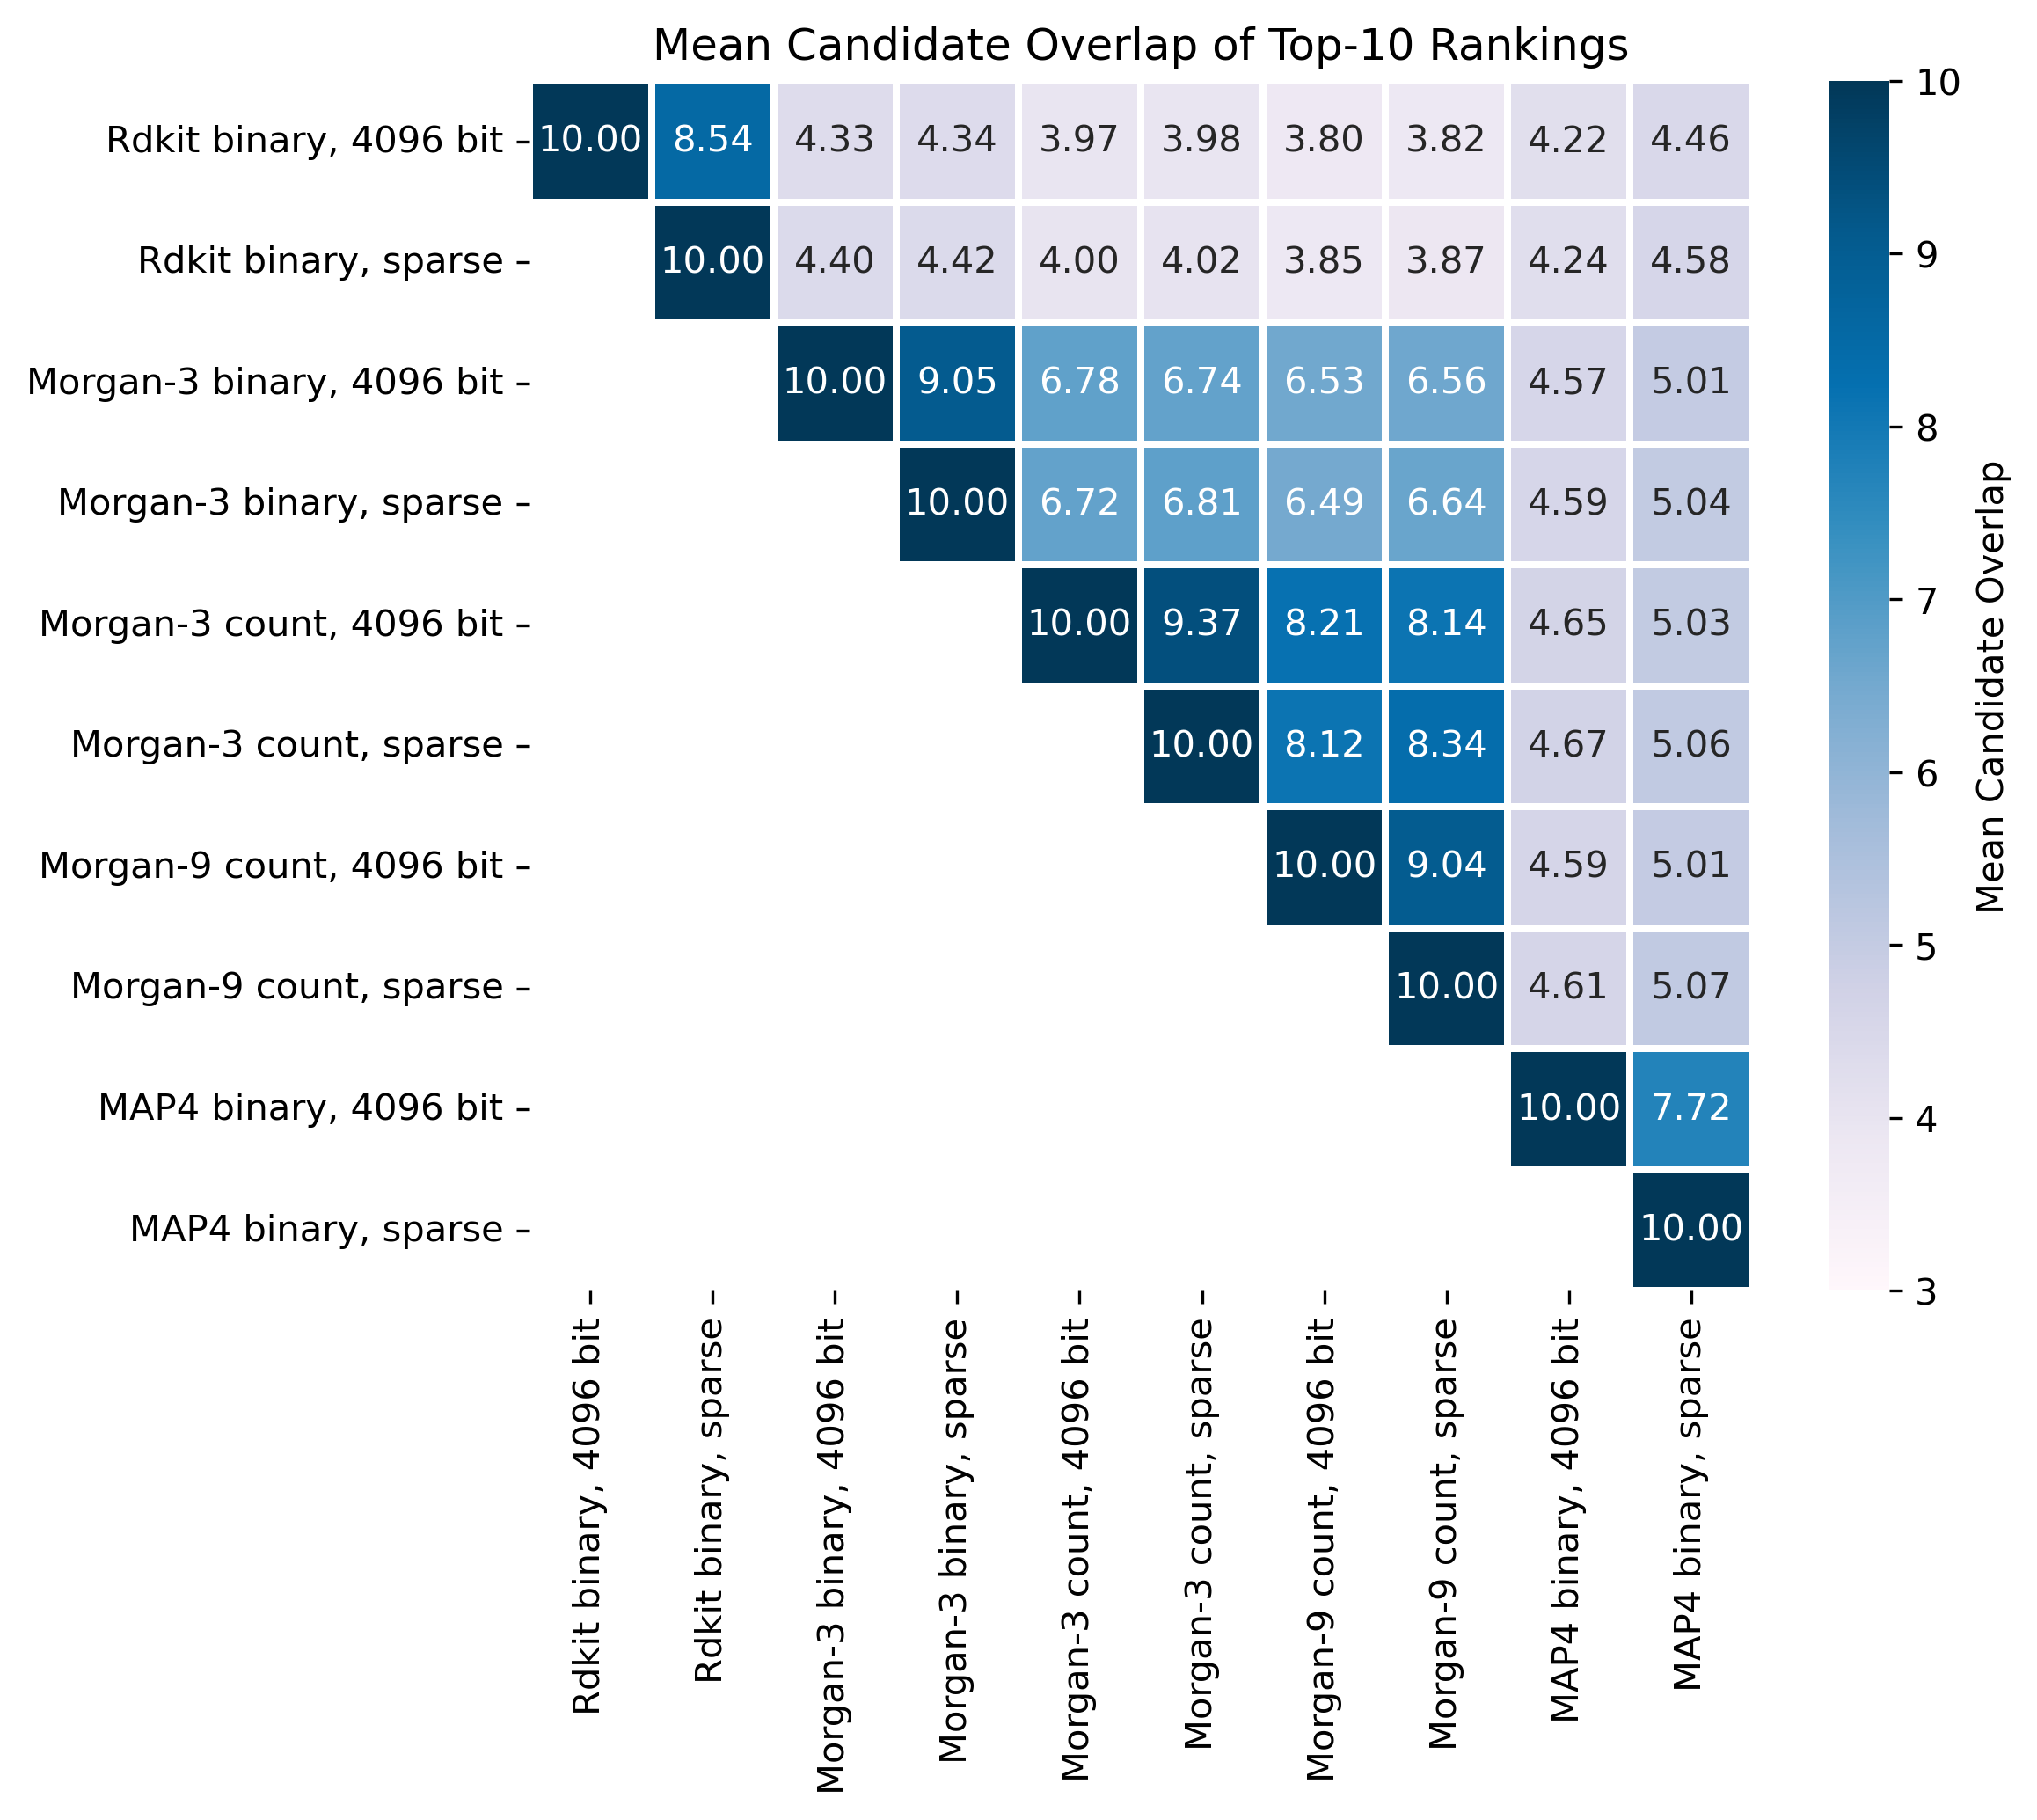

In [17]:
import seaborn

labels = ["Rdkit binary, 4096 bit",
          "Rdkit binary, sparse",
          "Morgan-3 binary, 4096 bit",
          "Morgan-3 binary, sparse",
          "Morgan-3 count, 4096 bit",
          "Morgan-3 count, sparse",
          "Morgan-9 count, 4096 bit",
          "Morgan-9 count, sparse",
          "MAP4 binary, 4096 bit",
          "MAP4 binary, sparse",
         ]


nn1 = 10
nn2 = 10
mask = np.tril(np.ones_like(overlap_matrix, dtype=bool), k=-1)

# Set up the matplotlib figure.
plt.figure(figsize=(8, 7), dpi=300)

# Plot the heatmap.
seaborn.heatmap(overlap_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='PuBu',
            linewidths=1.5,  
            linecolor='white',
            vmin=3, 
            #vmax=10,
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Mean Candidate Overlap'})

#plt.title(f'Mean Overlap of Top-{nn1} and Top-{nn2} Rankings')
plt.title(f'Mean Candidate Overlap of Top-10 Rankings')
plt.tight_layout()
plt.savefig("Top10_overlaps_all_scores.png", dpi=450)
plt.savefig("Top10_overlaps_all_scores.pdf")
plt.show()

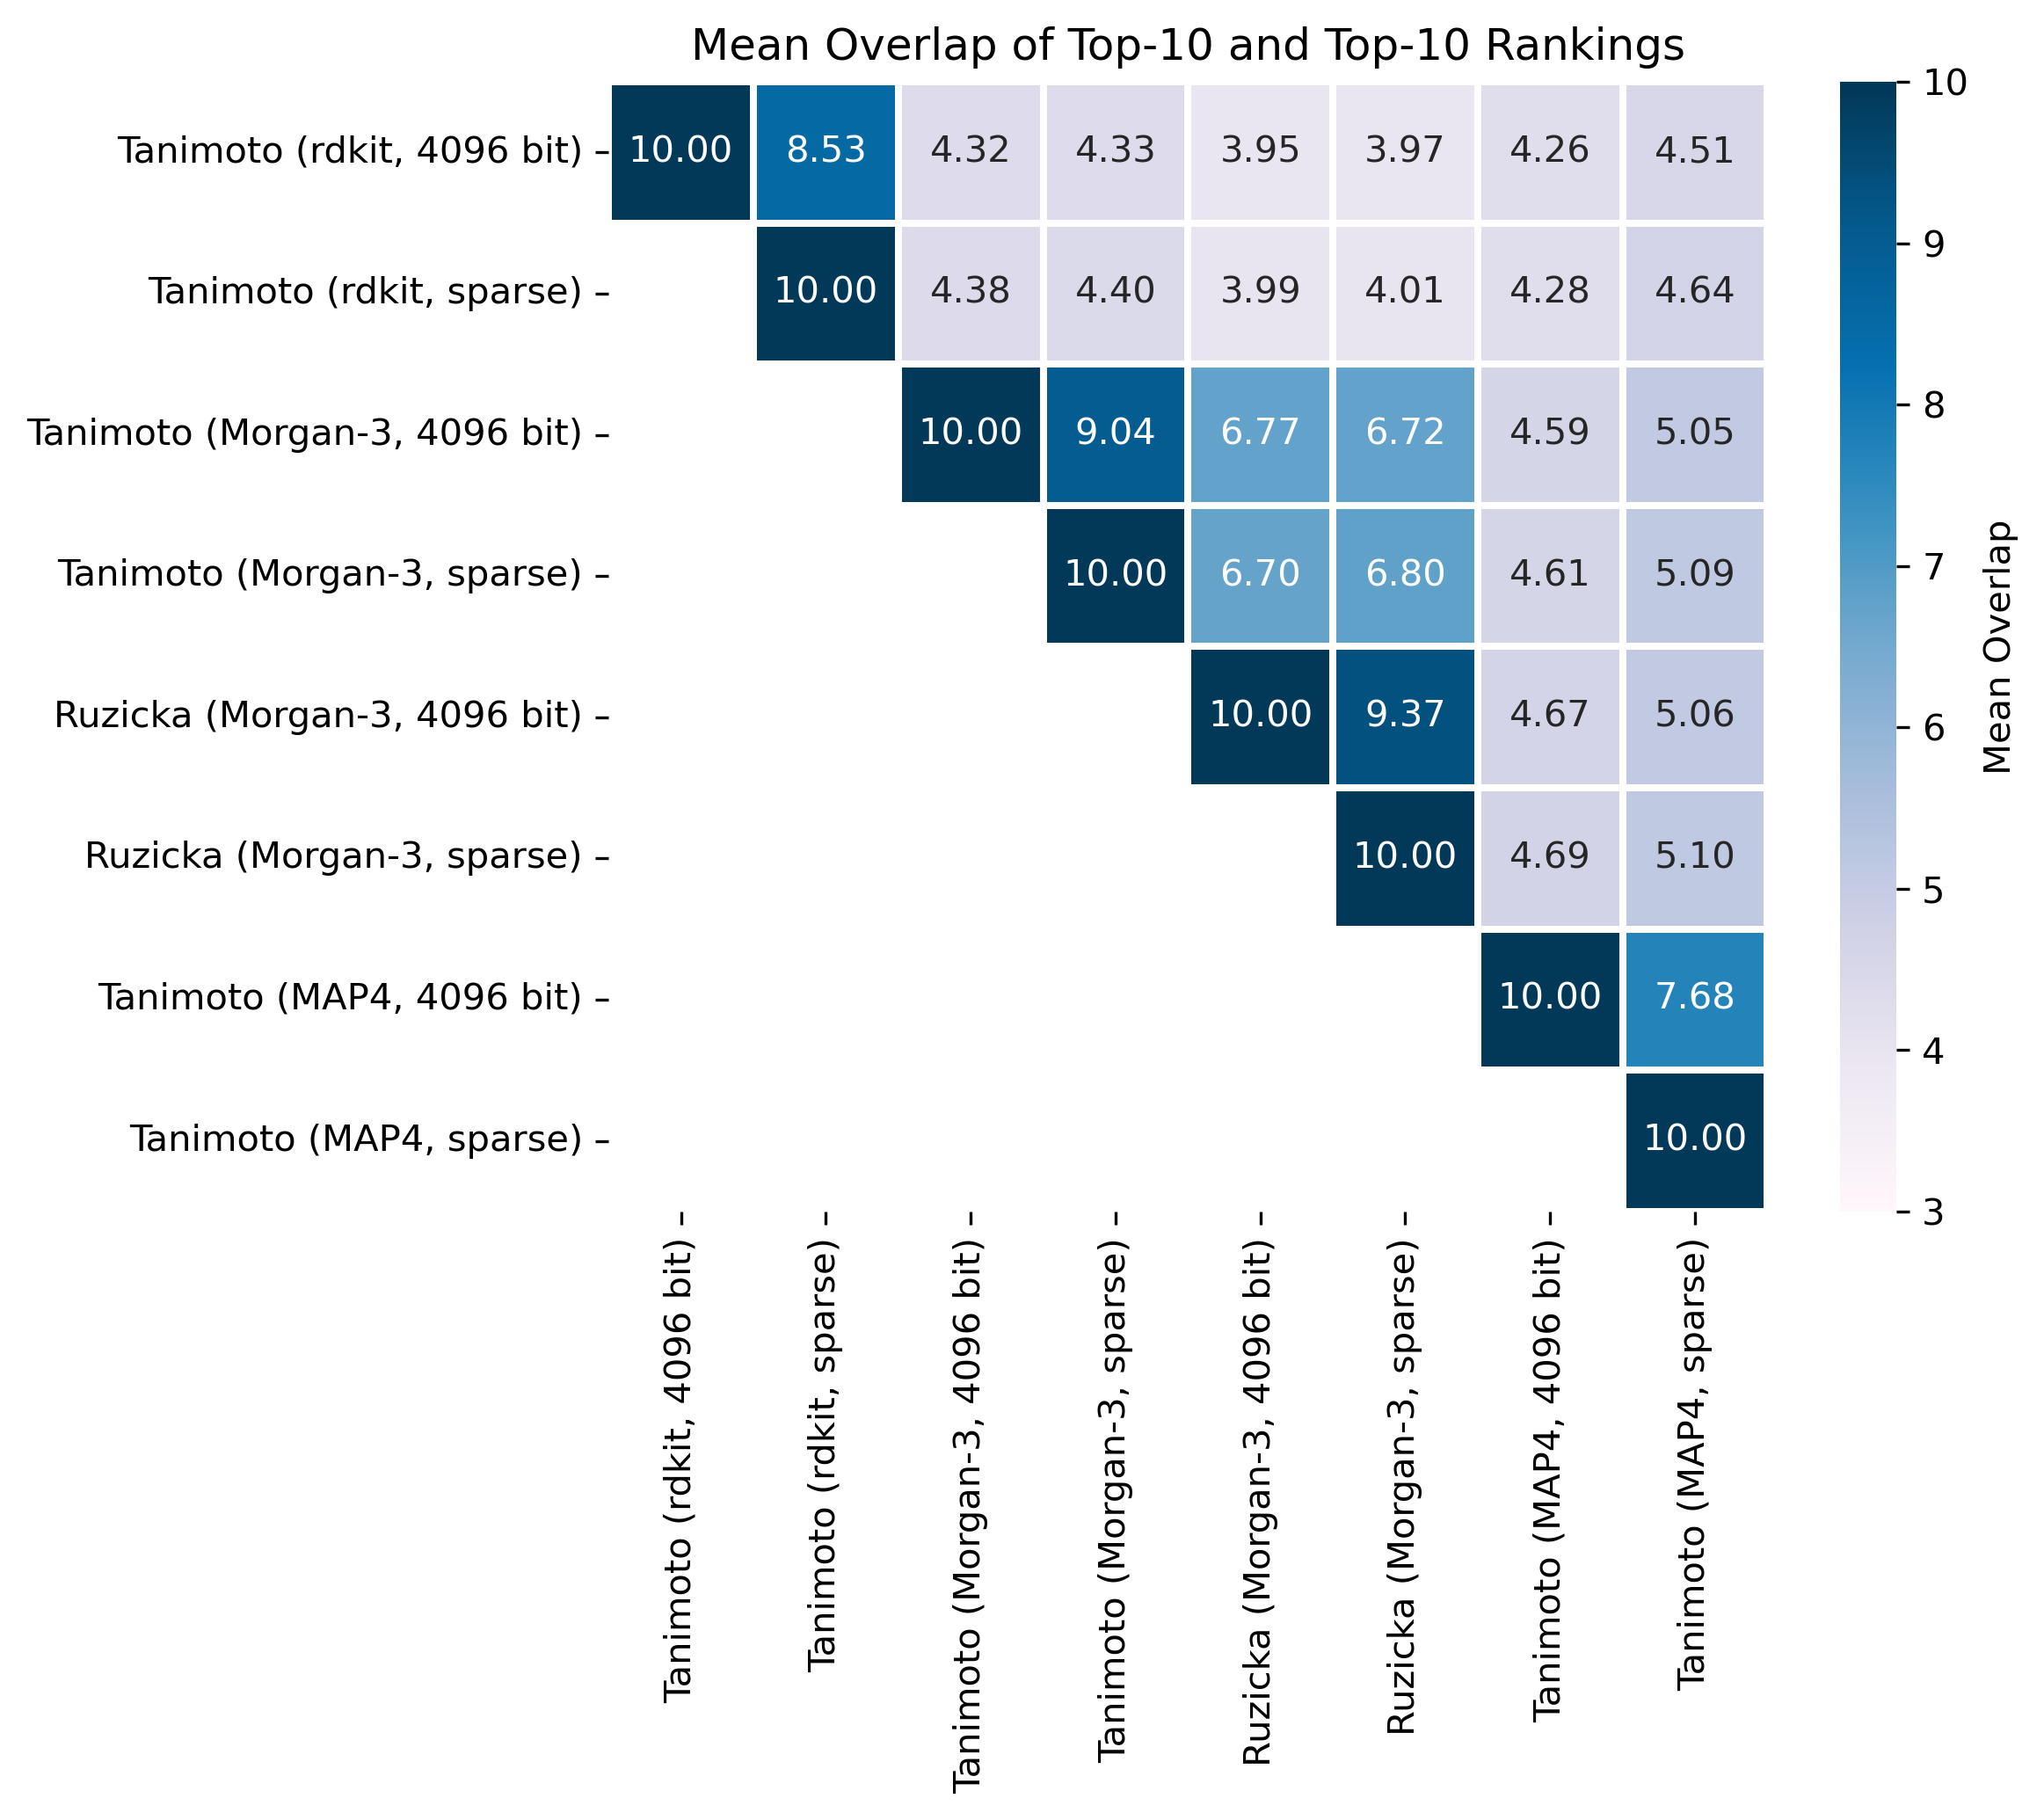

In [34]:
nn1 = 10
nn2 = 10
mask = np.tril(np.ones_like(overlap_matrix, dtype=bool), k=-1)

# Set up the matplotlib figure.
plt.figure(figsize=(8, 7), dpi=300)

# Plot the heatmap.
seaborn.heatmap(overlap_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='PuBu',
            linewidths=1.5,  
            linecolor='white',
            vmin=3, 
            #vmax=10,
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Mean Overlap'})

plt.title(f'Mean Overlap of Top-{nn1} and Top-{nn2} Rankings')
plt.tight_layout()
#plt.savefig("Top10_overlaps_all_scores.png")
#plt.savefig("Top10_overlaps_all_scores.pdf")
plt.show()

In [35]:
nn1 = 3
nn2 = 10

labels = ["Tanimoto (rdkit, 4096 bit)",
          "Tanimoto (rdkit, sparse)",
          "Tanimoto (Morgan-3, 4096 bit)",
          "Tanimoto (Morgan-3, sparse)",
          "Ruzicka (Morgan-3, 4096 bit)",
          "Ruzicka (Morgan-3, sparse)",
          "Tanimoto (MAP4, 4096 bit)",
          "Tanimoto (MAP4, sparse)",
         ]

overlap_matrix_2 = compare_multiple_scores(
    [
    scaled_similarities_rdkit,
    scaled_similarities_rdkit_sparse,
    scaled_similarities_morgan3,
    scaled_similarities_morgan3_sparse,
    scaled_similarities_morgan3_count,
    scaled_similarities_morgan3_count_sparse,
    scaled_similarities_map4,
    scaled_similarities_map4_sparse
    ],
    labels,
    nn1=nn1,
    nn2=nn2,
    sample_size=scaled_similarities_rdkit.shape[0]
    )

100%|█████████████████████████████████████████████| 8/8 [05:56<00:00, 44.52s/it]


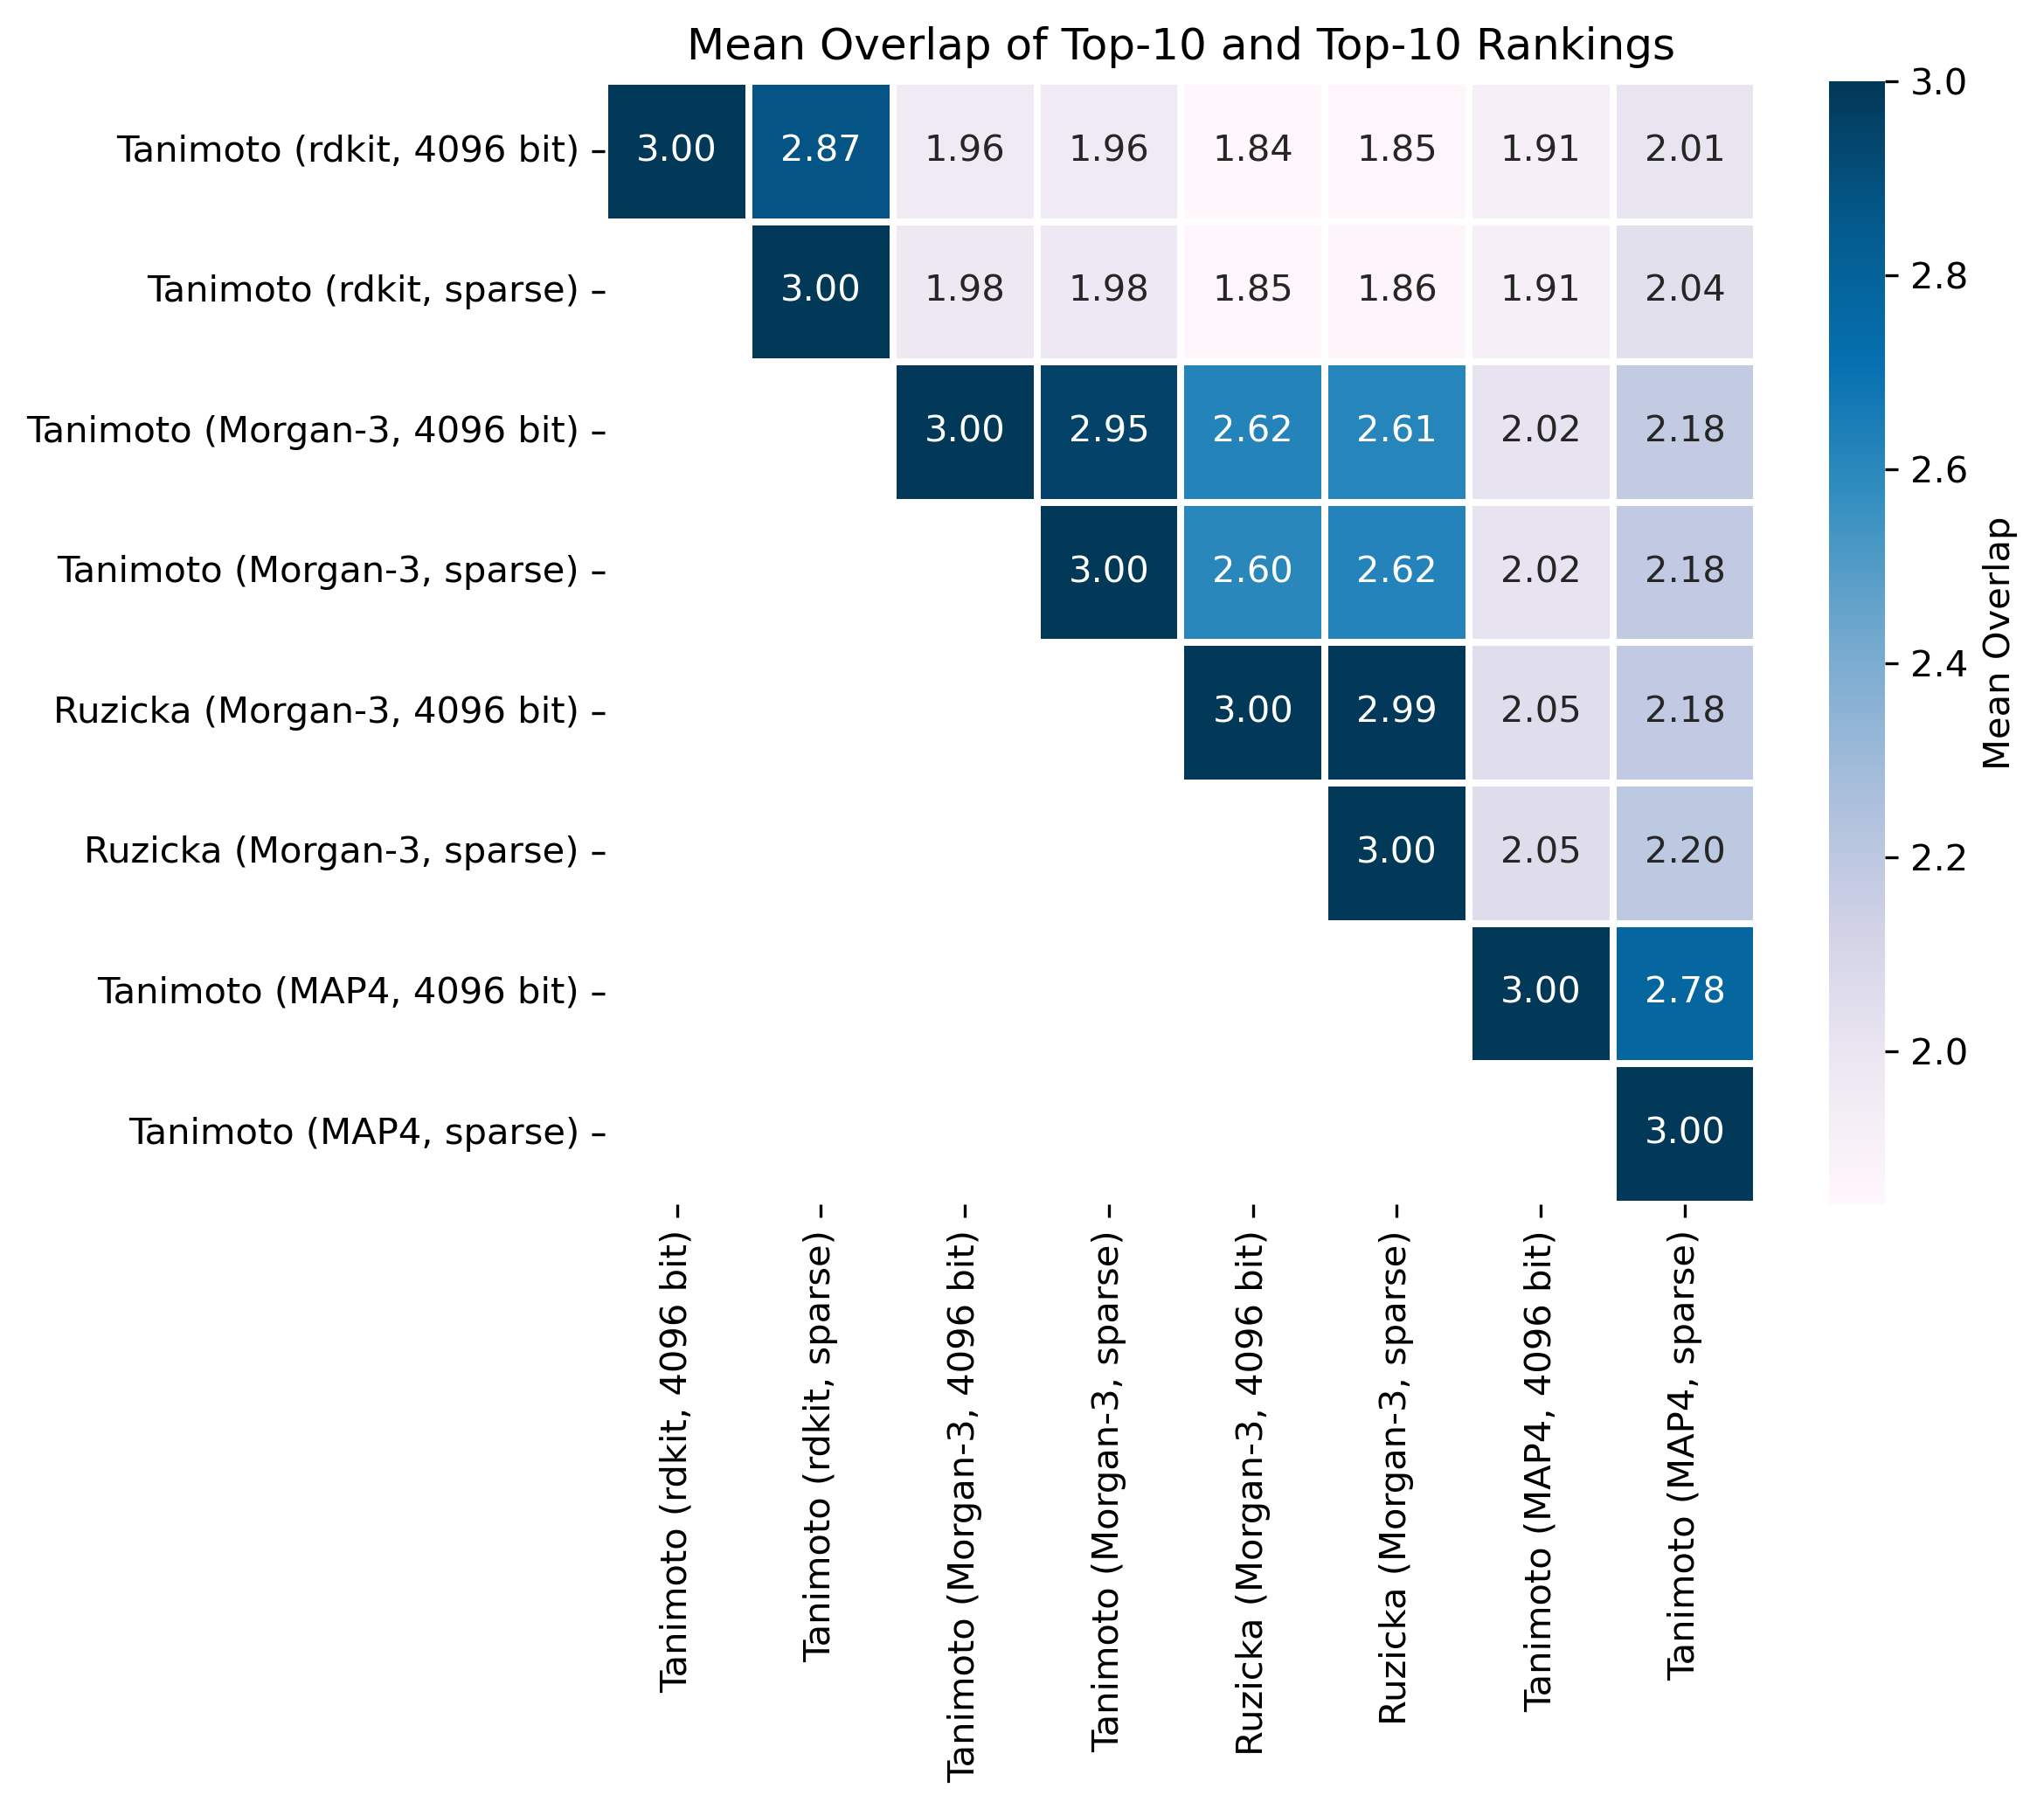

In [36]:
nn1 = 10
nn2 = 10
mask = np.tril(np.ones_like(overlap_matrix, dtype=bool), k=-1)

# Set up the matplotlib figure.
plt.figure(figsize=(8, 7), dpi=300)

# Plot the heatmap.
seaborn.heatmap(overlap_matrix_2,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='PuBu',          
            linewidths=1.5,
            linecolor='white',       # Color for the grid lines.
            #vmin=3,
            #vmax=10, 
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Mean Overlap'})

plt.title(f'Mean Overlap of Top-{nn1} and Top-{nn2} Rankings')
plt.tight_layout()
plt.savefig("Top3_in_10_overlaps_all_scores.png")
plt.savefig("Top3_in_10_overlaps_all_scores.pdf")
plt.show()

(array([ 156.,  277.,  351.,  388.,  417.,  414.,  411.,  448.,  487.,
        1651.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

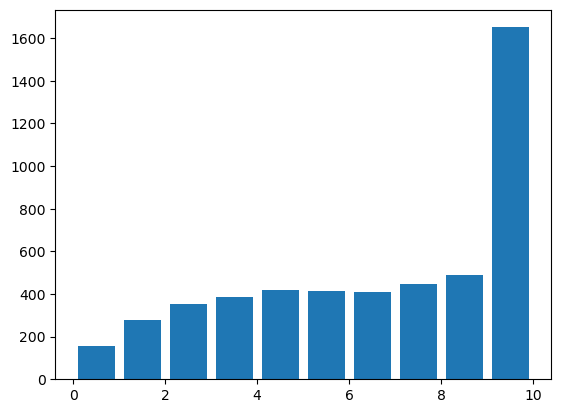

In [39]:
overlaps = total_overlaps(scaled_similarities_rdkit_sparse, scaled_similarities_morgan3_count_sparse, nn2=50)

plt.hist(overlaps[0], rwidth=0.8)

(array([  116.,   305.,   665.,  1078.,  1708.,  2256.,  2953.,  3823.,
         4550., 20209.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

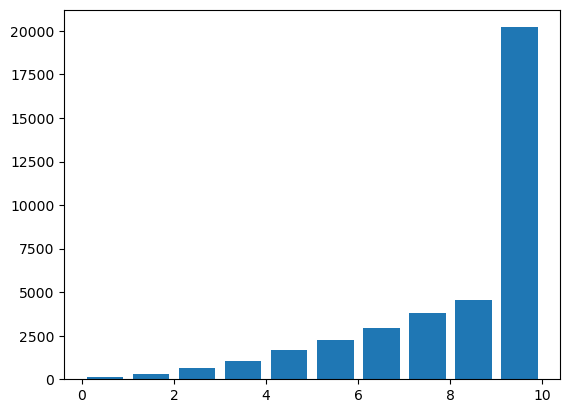

In [173]:
overlaps = total_overlaps(scaled_similarities_map4_sparse, scaled_similarities_morgan3_count_sparse, nn2=50, sample_size=37663)

plt.hist(overlaps[0], rwidth=0.8)

In [38]:
overlaps 

(array([ 7,  4,  5, ..., 10,  3, 10]),
 array([[99.68151 , 99.1737  ],
        [99.509315, 99.30674 ],
        [99.926605, 97.98754 ],
        ...,
        [99.99781 , 99.98326 ],
        [99.506935, 97.52581 ],
        [99.90419 , 99.58989 ]], dtype=float32))

In [174]:
little_overlap = np.where(overlaps[0] <= 1)[0]
print(little_overlap.shape)

(421,)


In [138]:
percentile_shifts = np.array([abs(x[0] - x[1]) for x in overlaps[1]])
percentile_shifts.max()

np.float32(45.347183)

In [75]:
little_overlap = np.where(percentile_shifts > 10)[0]
little_overlap

array([  44,   65,  769, 1116, 1178, 1627, 2082, 2134, 2391, 3922, 4425,
       4990])

In [54]:
from rdkit import Chem
from rdkit.Chem import Draw


def show_top_n(scores, idx, nn=5):
    closest = np.argsort(scores[idx, :])[-nn:][::-1]
    smiles1 = compounds.smiles[idx]
    mols = [Chem.MolFromSmiles(smiles1)]
    
    labels = ["Query compound"]
    
    for index in closest:
        labels.append(f"Score: {scores[idx, index]:.4f}")
        mols.append(Chem.MolFromSmiles(compounds.smiles[index]))
    
    display(Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(800, 800), returnPNG=False, 
                         #labels=labels
                        ))

def compare_top_n(scores_list, idx, nn=5):
    for scores in scores_list:
        show_top_n(scores, idx, nn)

10237


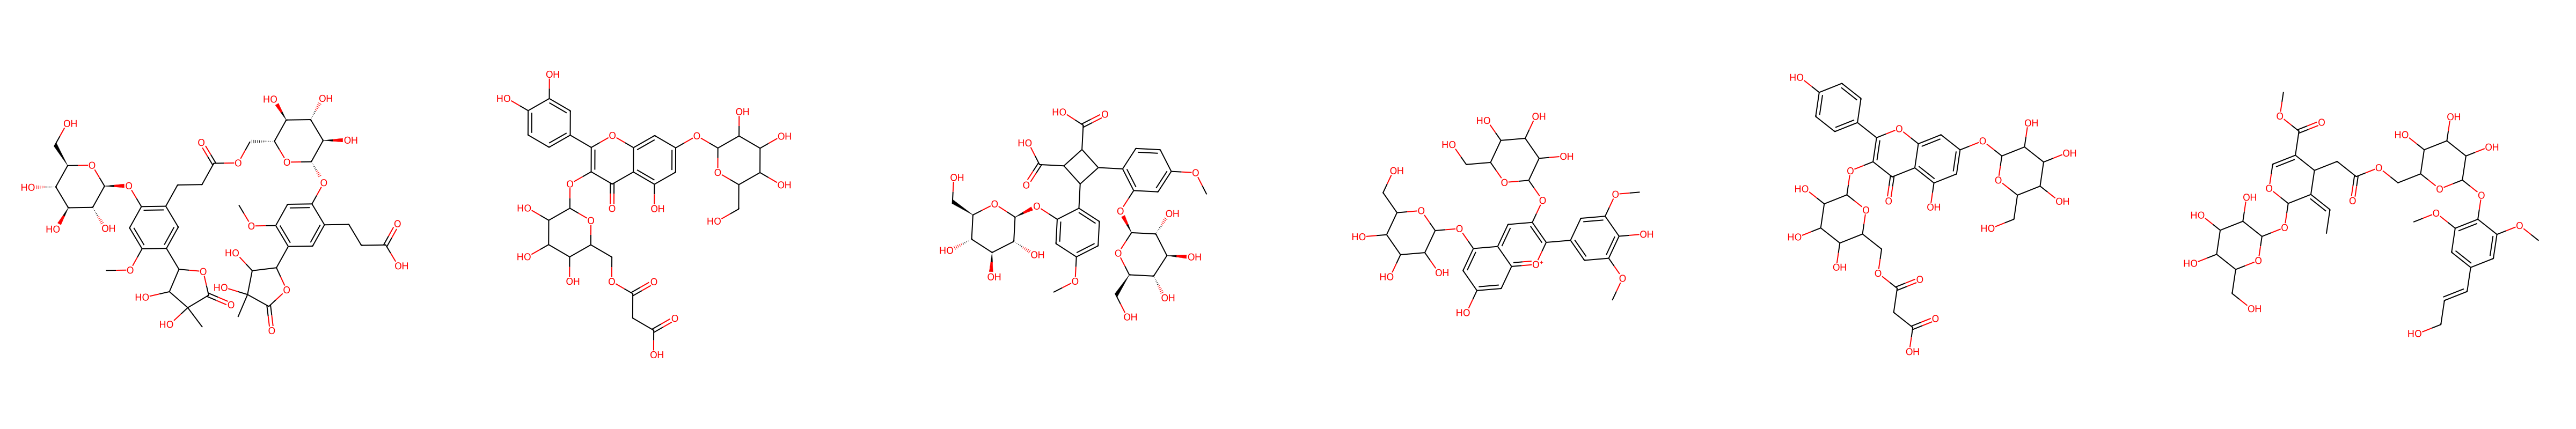

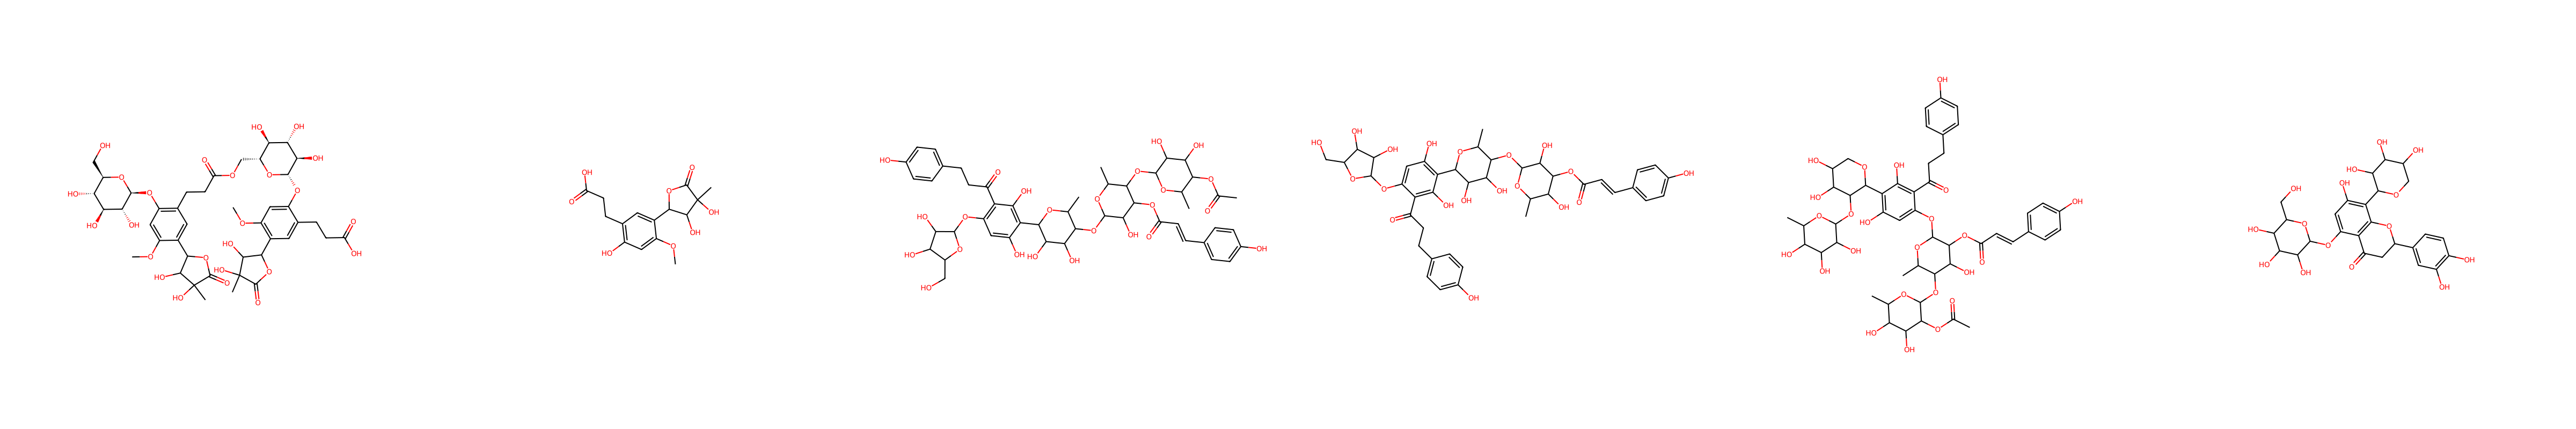

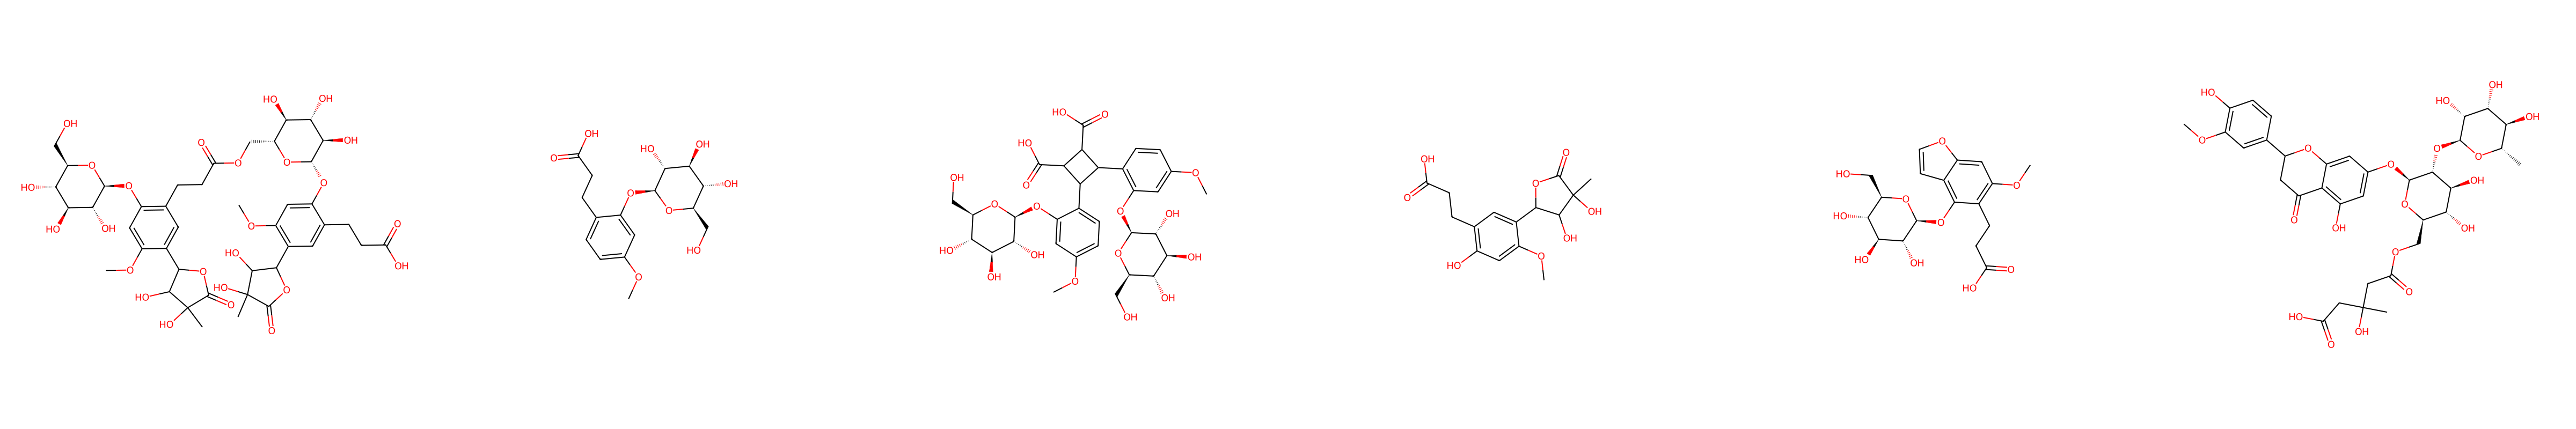

In [245]:
nn = 5
idx = little_overlap[109]  

# idx 54, 90, 122, 164, 177, 220, 319, 344, 464!, 486, 499, 525, 663, 741!, 867!, 37299 (count), 37109, 37078 (rdkit bad)
# 36920 (small mol), 36631 (map4 best), 35289 (morgan bad), 34355 (map4 bad), 8923 (large), 10237 (count)

#idx = 741
print(idx)

compare_top_n(
    [scaled_similarities_morgan3_count_sparse,
     scaled_similarities_rdkit_sparse,
     scaled_similarities_map4_sparse
    ],
     idx)